<a href="https://colab.research.google.com/github/bjornoshake/Lyrics-Generator/blob/gh-pages/KDD99_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
! wget -N http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz
! gunzip -f kddcup.data.gz
! wget -N http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
! tail -n +2 kddcup.names > kddcup.names.no_headers
! features=""; while read line; do features=$features,$(echo "$line" | cut -d':' -f 1); done< kddcup.names.no_headers; echo "${features:1},label">features
! cat features kddcup.data > dataset && head dataset && wc -l dataset
! head -n 1000000 dataset > dataset_reduced

--2020-05-21 16:20:44--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18115902 (17M) [application/x-gzip]
Saving to: ‘kddcup.data.gz’

kddcup.data.gz      100%[===================>]  17.28M  20.1MB/s    in 0.9s    

2020-05-21 16:20:45 (20.1 MB/s) - ‘kddcup.data.gz’ saved [18115902/18115902]

--2020-05-21 16:20:51--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘kddcup.names’ not modified on server. Omitting download.

duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_r

In [ ]:
import pandas as pd #Pour l'affichage des tableaux
import numpy as np
import math
import matplotlib.pyplot as plt #Pour les graphiques
import os
import sys

!wget -N https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/feature_engineering.py
import visualization
from visualization import plot_conf_mat, plot_feature_importances


from pandas.plotting import scatter_matrix

! pip install category_encoders
import category_encoders as ce

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn import decomposition
# May not work in the old versions of scikit-learn
from sklearn.metrics import plot_confusion_matrix  
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

from imblearn.over_sampling import SMOTE


!pip install ipython-autotime # To show time at each cell
                              # Credits to https://medium.com/@arptoth/how-to-measure-execution-time-in-google-colab-707cc9aad1c8
%load_ext autotime

# The following is to be able to mount Google Drive
from google.colab import drive

import pickle # To save the model
from os.path import isfile


--2020-05-21 16:21:03--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13008 (13K) [text/plain]
Saving to: ‘visualization.py’

visualization.py    100%[===================>]  12.70K  --.-KB/s    in 0.01s   

Last-modified header missing -- time-stamps turned off.
2020-05-21 16:21:03 (1.03 MB/s) - ‘visualization.py’ saved [13008/13008]

--2020-05-21 16:21:04--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserco

In [ ]:
plt.style.use('seaborn')
attack_categories = {'other': ['normal.'], 'dos': ['back.', 'land.', 'neptune.', 'pod.', 'smurf.', 'teardrop.'], 'u2r': ['buffer_overflow.', 'loadmodule.', 'perl.', 'rootkit.'], 'r2l': ['ftp_write.', 'guess_passwd.', 'imap.', 'multihop.', 'phf.', 'spy.', 'warezclient.', 'warezmaster.'], 'probe': ['ipsweep.', 'nmap.', 'portsweep.', 'satan.']}
attack_category_by_label = {label: attack 
                            for (attack, labels) in attack_categories.items()
                            for label in labels }
color_per_attack = {
    "dos": "red",
    "probe": "blue",
    "r2l": "lime",
    "u2r": "purple",
    "other": "black"
}

time: 7.52 ms


# Préparation du dataset

In [ ]:
dfp = pd.read_csv('dataset_reduced',sep=',')
dfp.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


time: 3.15 s


## One-Hot

In [ ]:
encoder = ce.OneHotEncoder(cols=['service', 'protocol_type', 'flag'], use_cat_names=True)
df_encoded = encoder.fit_transform(dfp)

time: 14.9 s


## Filtrage (ou non) des connexions normales

In [ ]:
# Commenter cette ligne pour travailler avec les connexions normales aussi dans la suite
df_encoded = df_encoded.query("label != 'normal.'")

time: 389 ms


## Traitement

In [ ]:
label_array = [a for k,v in attack_categories.items() for a in v]
dictionnary = { label : label_array.index(label) for label in label_array }
dfpr = df_encoded.replace({'label' : dictionnary})

X = dfpr.drop(labels='label', axis=1)
y = dfpr['label']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, 
                                        shuffle=True, random_state=4)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

time: 2.5 s


# ACP

## Détermination du nombre de composantes

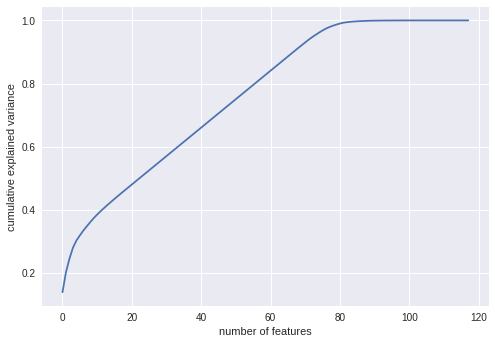

time: 8.02 s


In [ ]:
pca = decomposition.PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of features')
plt.ylabel('cumulative explained variance');

## Execution de l'ACP

In [ ]:
pca = decomposition.PCA(n_components=80)
pca.fit(X_train)
X = pca.transform(X_train)
y = y_train

time: 12.9 s


## Visualisation 3D

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice.
  if sys.path[0] == '':
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


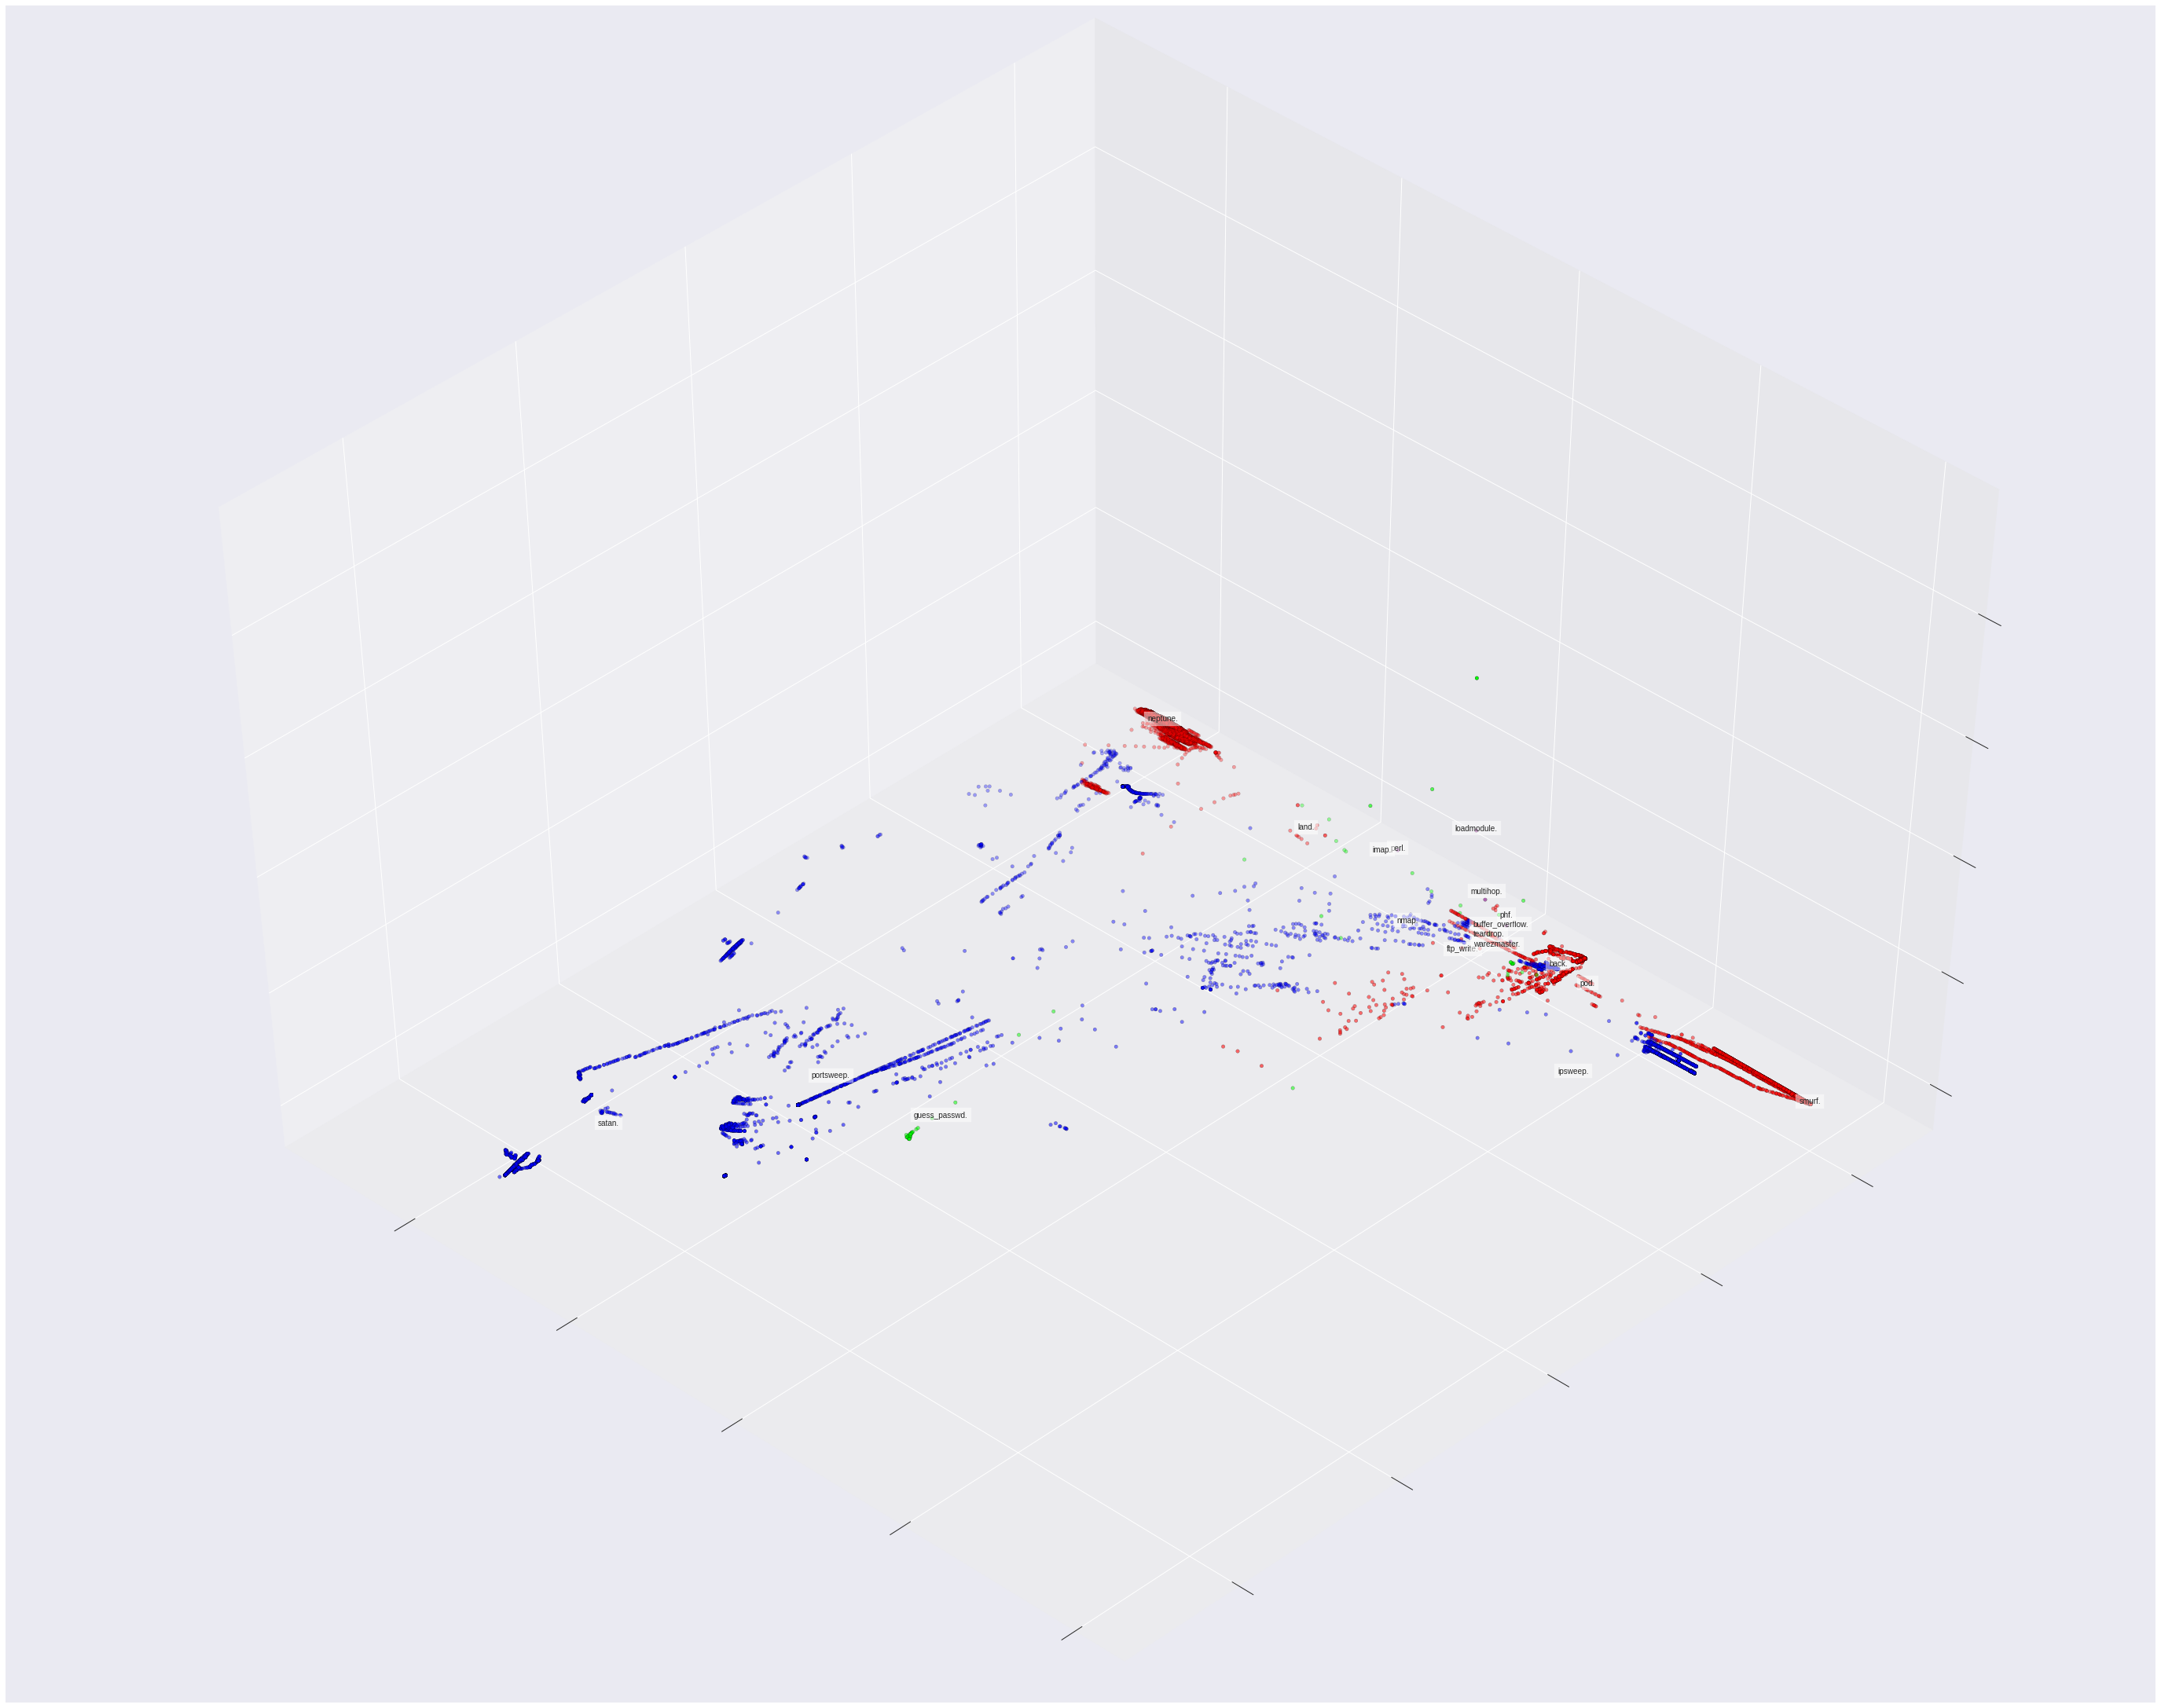

time: 6.11 s


In [ ]:
centers = [[1, 1], [-1, -1], [1, -1]]

fig = plt.figure(1, figsize=(40, 30))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

for i in range(len(label_array)):
    ax.text3D(X[y_train == i, 0].mean(),
              X[y_train == i, 1].mean(),
              X[y_train == i, 2].mean(), label_array[i],
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
color_by_label = {k: color_per_attack[v] for k, v in attack_category_by_label.items()}
y = np.choose(y, [color_by_label[label_array[i]] for i in range(len(label_array))])
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y,
           edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

## Features les plus impactante sur chacun des composants

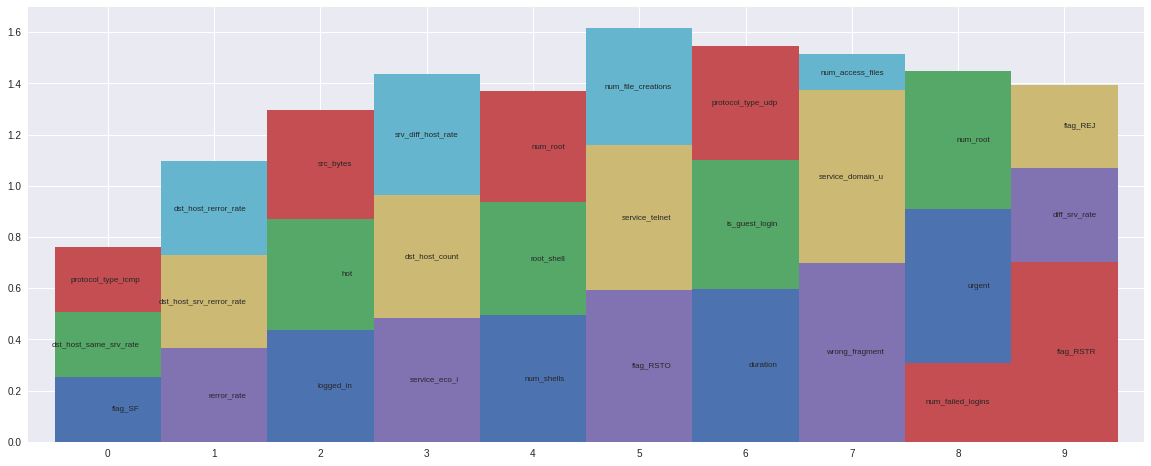

time: 2.36 s


In [ ]:
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# note: argsort sorts by ascending, so we read from the tail using [::-1]
most_important = [np.abs(pca.components_[i]).argsort()[::-1][:3] for i in range(n_pcs)]


most_important_bis = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
cols = df_encoded.drop("label", axis=1).columns

# get the names
most_important_names = []
for i in range(n_pcs):
  arr = {}
  for j in range(len(most_important[i])):
    arr[cols[most_important[i][j]]] = np.abs(pca.components_[i][most_important[i][j]])
  most_important_names.append(arr)

df = pd.DataFrame(most_important_names)
ax = df.head(n=10).plot(stacked=True, kind='bar', figsize=(20, 8), rot='horizontal', width=1)
ax.get_legend().remove()

flattened_values = [k for x in most_important_names for (k,v) in x.items()]
i = 0
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    #print(f'{height}')
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the data value and can used as the label
    label_text = flattened_values[i]  # f'{height:.2f}' to format decimal values

    # ax.text(x, y, text)
    label_x = x + width - 0.2  # adjust 0.2 to center the label
    label_y = y + height / 2
    if height != 0.0:
      ax.text(label_x, label_y, label_text, ha='right', va='center', fontsize=8)
      i+=1

## Visualisation générale

In [ ]:
pca_data = np.c_[X, y_train]

time: 61.5 ms


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=Fa

Text(0.5, 0.98, 'Average projection value on each axis for each label type')

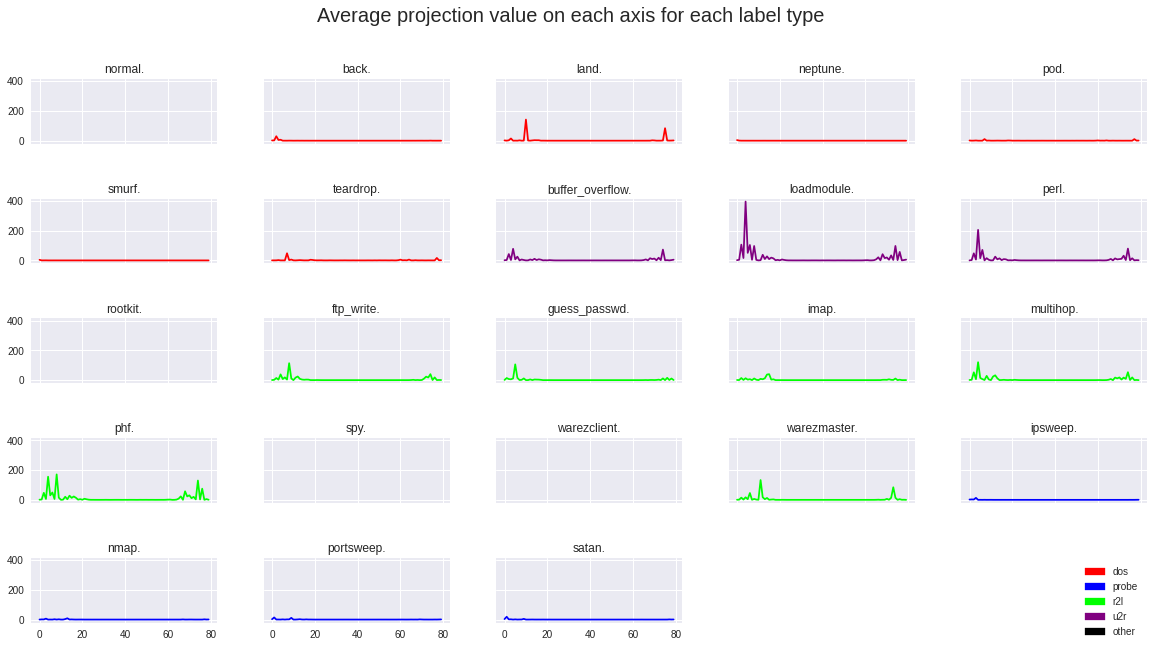

time: 4.79 s


In [ ]:
size = int(math.sqrt(len(label_array)))
if size**2 < len(label_array):
  size += 1
f, axes = plt.subplots(size, size, sharey=True, sharex=True, figsize=(20, 10))
for i in range(len(label_array)):
  label = label_array[i]
  possible_attack_type = [a_type for a_type, attacks in attack_categories.items() if label in attacks]
  attack_type = "other" if len(possible_attack_type) == 0 else possible_attack_type[0]
  ax = axes[i//size][i%size]
  ax.plot([i for i in range(pca.n_components_)], np.absolute(pca_data[:,:-1][pca_data[:,-1] == i].mean(axis=0)), color=color_per_attack[attack_type])
  ax.title.set_text(label)

for i in range(len(label_array), size**2):
  axes[i//size, i%size].axis('off')
import matplotlib.patches as mpatches
legend = []
for attack, colour in color_per_attack.items():
  legend.append(mpatches.Patch(color=colour, label=attack))

plt.legend(handles=legend)
plt.subplots_adjust(wspace=0.25,hspace=0.85)
plt.suptitle("Average projection value on each axis for each label type", size=20)